# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading
2. Dictionary generation
3. Data preprocessing
4. Model (neural network) training
5. Text generation (model evaluation)

### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

**Alternatively**

You could use file `onegin.txt` with Russian texts or your natve language poetry to be able to assess results quality.

**Note: In case of Onegin text you need to adjust reading procedure yourself!!!** (this file has a bit different format than `sonnets.txt`)

In [1]:
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/sonnets.txt
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/onegin.txt

--2025-05-28 10:00:04--  https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/sonnets.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 119748 (117K) [text/plain]
Сохранение в: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116,94K  --.-KB/s    за 0,08s   

2025-05-28 10:00:05 (1,41 MB/s) - ‘sonnets.txt’ сохранён [119748/119748]

--2025-05-28 10:00:05--  https://raw.githubusercontent.com/v-goncharenko/madmo-adv/55d929befa12370fc18109f5333f7cf000ea27ce/homeworks/onegin.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.13

In [2]:
with open("sonnets.txt", "r") as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
import string

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = ''.join(text).lower()

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: idx for idx, char in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = {idx: char for char, idx in token_to_idx.items()}

In [7]:
print(f"Всего токенов: {len(tokens)}")
print(f"Пример token_to_idx: {list(token_to_idx.items())[:5]}")

Всего токенов: 38
Пример token_to_idx: [('\n', 0), (' ', 1), ('!', 2), ("'", 3), ('(', 4)]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [ ]:
"""
Для начала подготовим пары входов и целевых значений (X, Y). Затем преобразуем символы в индексы.
"""
import torch

seq_length = 40
step = 3  # шаг скольжения окна
X = []
Y = []

for i in range(0, len(text) - seq_length, step):
    X.append(text[i: i + seq_length])
    Y.append(text[i + seq_length])

print(f"Количество обучающих примеров: {len(X)}")

Количество обучающих примеров: 33395


In [9]:
"""
преобразуем символы в индексы.
"""
# Преобразуем X и Y в числовые индексы
X_idx = [[token_to_idx[char] for char in seq] for seq in X]
Y_idx = [token_to_idx[char] for char in Y]

In [16]:
"""Теперь преобразуем данные в тензоры и создадим свой класс Dataset для PyTorch."""
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Создаем dataset и dataloader
dataset = CharDataset(X_idx, Y_idx)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [19]:
"""Посмотрим что за пример возвращает dataloader"""
X_batch, Y_batch = next(iter(dataloader))
print(X_batch.shape)
print(Y_batch.shape)

torch.Size([128, 40])
torch.Size([128])


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [21]:
# Your code here
import torch.nn as nn

class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, vocab_size)  # one-hot как embedding
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # x -> (batch_size, seq_len, vocab_size)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # берём выход последнего временного шага
        return out, hidden

In [22]:
vocab_size = len(tokens)
hidden_size = 128
model = CharRNN(vocab_size, hidden_size)

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for X_batch, Y_batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

/tmp/ipykernel_6506/728791500.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  epoch_loss += loss.item()


Epoch 1, Loss: 2.2314
Epoch 2, Loss: 1.9040
Epoch 3, Loss: 1.7848
Epoch 4, Loss: 1.7111
Epoch 5, Loss: 1.6594
Epoch 6, Loss: 1.6155
Epoch 7, Loss: 1.5793
Epoch 8, Loss: 1.5460
Epoch 9, Loss: 1.5207
Epoch 10, Loss: 1.4967


Plot the loss function (axis X: number of epochs, axis Y: loss function).

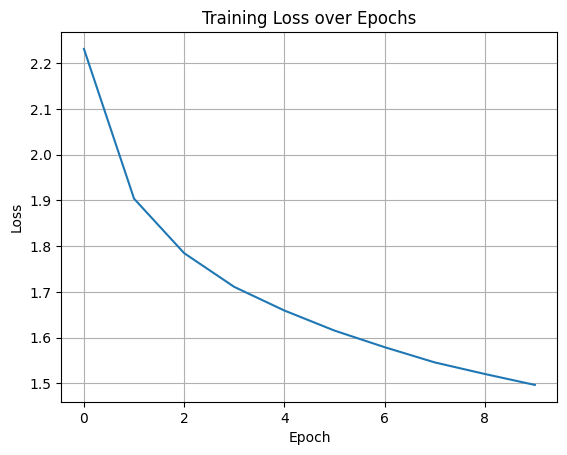

In [24]:
# Your plot code here
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [26]:
# An example of generated text. There is no function `generate_text` in the code above.
# print(generate_text(length=500, temperature=0.2))
import numpy as np

def generate_text(model, start_text, length=200, temperature=1.0):
    model.eval()
    input_seq = [token_to_idx[c] for c in start_text.lower()]
    input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0)  # (1, seq_len)
    
    hidden = None
    generated = start_text

    for _ in range(length):
        output, hidden = model(input_tensor, hidden)
        output = output / temperature
        probs = torch.softmax(output, dim=-1).data.numpy().ravel()
        next_idx = np.random.choice(len(tokens), p=probs)
        next_char = idx_to_token[next_idx]
        
        generated += next_char
        input_tensor = torch.tensor([[next_idx]], dtype=torch.long)

    return generated

In [30]:
print(generate_text(model, start_text="shall i compare thee", length=500, temperature=0.2))

shall i compare thee i from the forgen in the sull for the faires from my love the prainst the sumpous the filld the world the sull fill the sumpoute,
  that the sull self the mine eyes the faires for thine eyes thy love the forgen in the shall the summer's from my love the faires from my love the forger him from my love the world the faires from my love that in the faires of thy filling the faires from my love the faires from the sweet thine eyes the faires for the face of thy for the faires from my love the sumpo


Стиль: Очень повторяющийся и предсказуемый.
Слова: Почти всегда корректные и встречаются в оригинальных сонетах.
Смысл: Низкий — текст грамматически стабильный, но смысл теряется из-за частых повторов.

In [ ]:
"""А если сравнить температуры?"""
temps = [0.5, 1.0, 1.5, 2.0]
for t in temps:
    print(f"\n--- Temperature: {t} ---")
    print(generate_text(model, start_text="shall i compare thee", length=300, temperature=t))


--- Temperature: 0.5 ---
shall i compare thee i not do it hell my him gring that lame my love the sumber'st the sunls the least in the filld shame,
    for shall,
  the humble, for thee.
  thy storn,
  to treast,
  and my much thee, that thy fairer the fell the thou all the heart my him excisting my love thee the forget fill for the sumpes fro

--- Temperature: 1.0 ---
shall i compare thee preauty on thance hid in in trise, thah gabpen.

  cqutyers my love thy out their ensicless age is merift mike as your living than'd thy dowers with hance.
  but gress,
  i could the hes imantalfe,
    from time dosh the mack, likes forbodce that is him forth me hhe is thinis for thy clains of me,


--- Temperature: 1.5 ---
shall i compare thee; no newul'd changl
  thee moung, thy flove
u eves werows in jelovidink worts, sixcy such, if a lorl'ft is wacaustlooted, yet well is seet thy one,
  thus muik of as these, ire tyro in vese livath, ared,
  not  artid mine---yif

  parues imire eye had'd certss

Вывод:
Значения 0.5–1.0 дают оптимальный баланс между структурой и креативностью.
1.5+ — отлично для генеративного искусства, не для "читаемого" текста.

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [32]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, vocab_size)
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

In [33]:
model = CharLSTM(vocab_size=len(tokens), hidden_size=128)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for X_batch, Y_batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 2.2842
Epoch 2, Loss: 1.8752
Epoch 3, Loss: 1.7343
Epoch 4, Loss: 1.6365
Epoch 5, Loss: 1.5595
Epoch 6, Loss: 1.4968
Epoch 7, Loss: 1.4400
Epoch 8, Loss: 1.3912
Epoch 9, Loss: 1.3471
Epoch 10, Loss: 1.3017


LSTM достиг более низкой ошибки (~1.30 против ~1.49 у RNN).

Plot the loss function of the number of epochs. Does the final loss become better?

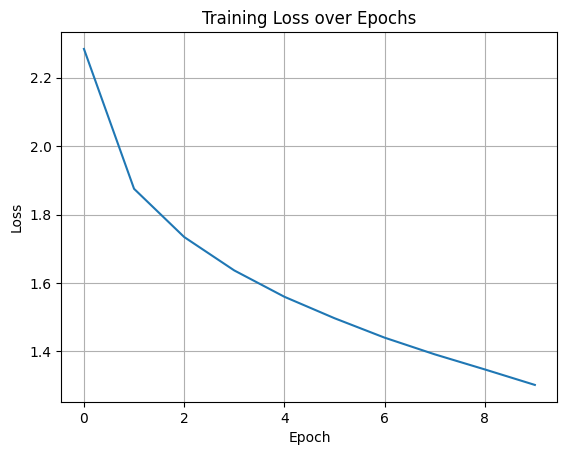

In [35]:
# Your beautiful code here
# Your plot code here
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [36]:
print(generate_text(model, start_text="shall i compare thee", length=500, temperature=0.5))

shall i compare thee.

  cxxxi

  that i have my with when i good and thee, wherefore may the world a conqure the with that did plack is sweet seem she please hath strangly singled deep
  to shalt still such that i from thee to chold is sourts think thee,
  and that this addith love thee worth livery and this self that thee, my heart that which to were are me, i mayst with thee,
  to have with in the pitious is the sweet seem fair,
  the summer's so grave wilf thee in thy sweet shall grews sweet gind
  to my moth h


Generate text using the trained net with different `temperature` parameter: `(0.1, 0.2, 0.5, 1.0, 2.0)`.

Evaluate the results visually, try to interpret them.

In [37]:
# Text generation with different temperature values here
"""А если сравнить температуры?"""
temps = [0.1, 0.2, 0.5, 1.0, 2.0]
for t in temps:
    print(f"\n--- Temperature: {t} ---")
    print(generate_text(model, start_text="shall i compare thee", length=300, temperature=t))


--- Temperature: 0.1 ---
shall i compare thee,
  the wilt i all the summer's such such the wine with thee thee, and such still doth dies his days shall beart,
    that i such the world thee, which the sund thee, which the see the world and thee, and thee, and thee, and thee, and thee, and thee, and thee, which the will of thee, which the see t

--- Temperature: 0.2 ---
shall i compare thee,
  and thee have the will of thy sweet self thee, and such the summer's say thee,
  and the will my such thy love and thee, and thee their with thee thee, which the wilt in thee:
    then some in thee the world the will of thy should thee, which the seem of my summer's spirit
  to me with my love a

--- Temperature: 0.5 ---
shall i compare thee.

  civ

  the world thee loves my his false i forgen i sourth with my sunce more my says me are rning,
  and that where the pleasure with thee with self thee, as the see show hand, so back as all to show the sweet seem
  thou mayst in the worth thou art the 

Вывод:
0.5–1.0 — лучшие значения для генерации поэзии.
LSTM действительно показывает более плавный, устойчивый и содержательный текст, чем RNN на тех же данных.

### Saving and loading models

Save the model to the disk, then load it and generate text.
Follow guides from [this tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

You need to use `Save/Load state_dict (Recommended)` section aka save state dict.

In [38]:
# Saving and loading code here
# Сохраняем state_dict
torch.save(model.state_dict(), "char_lstm_model.pth")
print("Модель сохранена как 'char_lstm_model.pth'")

Модель сохранена как 'char_lstm_model.pth'


In [39]:
# Воссоздание модели с той же архитектурой
model_loaded = CharLSTM(vocab_size=len(tokens), hidden_size=128)

# Загрузка state_dict
model_loaded.load_state_dict(torch.load("char_lstm_model.pth"))

# Перевод в режим оценки
model_loaded.eval()

# Проверка генерации
print(generate_text(model_loaded, start_text="shall i compare thee", length=300, temperature=0.5))

shall i compare thee,
  to being orn the place it to strong i their thy love and love, to me can in thy some to this abuse adder my conterth and reservent;
  the tongue-tien thou my heart spirite make a dayst the see hath with you shore, to being hath strange were eyem
  my say think mark thee, where thee:
    the will


## Additional materials on topic

1. [Andrew Karpathy blog post about RNN.](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)\
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with [PyTorch examples](https://github.com/spro/practical-pytorch`)

### Эта часть ислледования не относится к домашнему заданию, а всего лишь для личного любопытсва.

In [40]:
"""
Улучшенная модель LSTM
Изменения:
hidden_size = 256
num_layers = 2
добавлен embedding_dim = 64
"""
class CharLSTMImproved(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=256, num_layers=2):
        super(CharLSTMImproved, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # выход последнего временного шага
        return out, hidden

In [41]:
model = CharLSTMImproved(vocab_size=len(tokens))

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

n_epochs = 50
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for X_batch, Y_batch in dataloader:
        optimizer.zero_grad()
        output, _ = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 2.2023
Epoch 2, Loss: 1.7451
Epoch 3, Loss: 1.5765
Epoch 4, Loss: 1.4545
Epoch 5, Loss: 1.3613
Epoch 6, Loss: 1.2716
Epoch 7, Loss: 1.1822
Epoch 8, Loss: 1.0996
Epoch 9, Loss: 1.0102
Epoch 10, Loss: 0.9235
Epoch 11, Loss: 0.8427
Epoch 12, Loss: 0.7583
Epoch 13, Loss: 0.6835
Epoch 14, Loss: 0.6258
Epoch 15, Loss: 0.5598
Epoch 16, Loss: 0.5053
Epoch 17, Loss: 0.4541
Epoch 18, Loss: 0.4401
Epoch 19, Loss: 0.4139
Epoch 20, Loss: 0.3939
Epoch 21, Loss: 0.3801
Epoch 22, Loss: 0.3570
Epoch 23, Loss: 0.3322
Epoch 24, Loss: 0.3558
Epoch 25, Loss: 0.3567
Epoch 26, Loss: 0.3458
Epoch 27, Loss: 0.3113
Epoch 28, Loss: 0.2867
Epoch 29, Loss: 0.2875
Epoch 30, Loss: 0.3099
Epoch 31, Loss: 0.3398
Epoch 32, Loss: 0.3250
Epoch 33, Loss: 0.3043
Epoch 34, Loss: 0.3013
Epoch 35, Loss: 0.3143
Epoch 36, Loss: 0.3126
Epoch 37, Loss: 0.3163
Epoch 38, Loss: 0.3112
Epoch 39, Loss: 0.2927
Epoch 40, Loss: 0.2776
Epoch 41, Loss: 0.2875
Epoch 42, Loss: 0.3251
Epoch 43, Loss: 0.3198
Epoch 44, Loss: 0.33

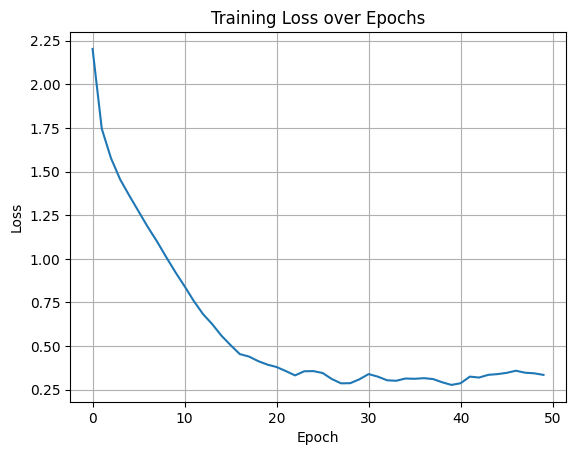

In [43]:
def plot_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.show()

plot_loss(loss_history)

25 Эпох достаточно, чтобы выйти на плато. Можно было использовать stop early.

In [44]:
print(generate_text(model, start_text="shall i compare thee", length=500, temperature=0.5))

shall i compare thee,
    and nene them my sin, and trought, than thy laves soors thou to doth unwort of thy spearing hath can bood fait,
  and pust beason what on a fresam'd lives the praises remembrancely give
  the capait apposed our friend'st thoughts all exame.
    for so should that i wan waster you hath my love's vies thou art me, atir'd, or hath my love and to thee:
    morrety on have i love thoughts outlive a did thee a lay the deciemence majusted;
  hath my eyes summer's come some virtuess of thy heart, 


Получилось наиболее качественно чем предыдущих моделях.